*A1 Report - Wu, Sixuan*
# <center> Exploring Yelp </center>
## <center> Author: Sixuan Wu </center>
## <center> Date: February 15, 2020 </center>
***

## Introduction

Yelp is a business directory service and crowd-sourced review forum, and a public company of the same name that is headquartered in San Francisco, California. The company develops, hosts, and markets the Yelp.com website and the Yelp mobile app, which publish crowd-sourced reviews about businesses. It also operates an online reservation service called Yelp Reservations.

--adapted from Wikipedia

## Data Description

The dataset I used is from [Yelp Dataset Challenge](https://www.yelp.com/dataset/challenge) which is provided by Yelp officially. The json format dataset which is compressed in tar format can be downloaded by providing email and name. Following are related [permissions](https://s3-media1.fl.yelpcdn.com/assets/srv0/engineering_pages/06cb5ad91db8/assets/vendor/yelp-dataset-agreement.pdf) of the dataset:

**Cannot Dos:**
- Use the data to create or update my own business.
- Give the data to the third party without permission of Yelp.
- Give the data to others to make profit.

**Can Dos:**
- Use information from data to do academic project in for this course.

### Extract Data

In [38]:
import tarfile
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go


In [2]:
# Downloaded dataset is in tar format, then extract dataset to json.
tf = tarfile.open("yelp_dataset.tar")
tf.extractall()

The downloaded data is in tar compressed file, the first thing is to extract data to json format data. There are several json formatted datasets after extraction:
- business.json
- checkin.json
- photo.json
- review.json
- tip.json
- user.json

### Observe Data

By observing the datasets listed above, here is the structure and relationship of those datasets:

| Dataset | Structure | Relationship 
|:--------|:-----------|:------------------------------
business.json | **business_id**: id to represent the merchant<br>**name:** name of the merchant<br>**address:** specific address of the merchant <br> **city:** city where the merchant located<br> **state:** state where the merchant located<br> **postal_code:** the postal code of the merchant<br> **latitude:** latitude of the merchant<br> **longitude:** longitude of the merchant<br>**stars:** stars given by customers <br>**review_count:** number of reviews provided by users<br>**is_open:** whether the shop/restautant open, 1 for yes and 0 for no<br>**attributes:** some special sevices provided by the merchant<br>**categories:** some features of the merchant<br>**hours:** opening hours of the restaurant| Detailed information of each merchants registered on yelp.
[checkin](https://blog.yelp.com/2018/12/perfect-yelp-check-in-offer).json | **business_id:** id of the merchant<br> **date:** exact time the bussiness check in | The exact check in time of the merchants which share the same business_id in business dataset.
user.json | **user_id:** id of the user<br>**name:** name of the user<br>**review_count:** number of reviews given by the user<br>**yelping_since:** time the user join in Yelp<br>**useful:** number of useful recieved by the user<br>**funny:** number of funny recieved by the user<br>**cool:** number of cool recieved by the user<br>**[elite](https://www.yelp-support.com/article/What-is-Yelps-Elite-Squad?l=en_US):** the elite year of the user<br>**friends:** id of friends of the user<br>**fans:** number of fans of the user<br>**average_stars:** average stars given by the user<br>**compliment_hot:** number of recommandations the user compliment hot<br>**compliment_more:** number of recommandations the user compliment more<br>**compliment_profile:** number of profiles the user compliment<br>**compliment_cute** number of recommandations the user compliment cute<br>**comliment_list:** number of lists the user compliment<br>**compliment_note:** number of notes the user write for compliments<br>**compliment_plain:** number of recommandations the user compliment plain<br>**compliment_cool:** number of recommandations the user compliment cool<br>**compliment_funny:** number of recommandations the user compliment funny<br>**compliment_writers:** number of writers the user compliment<br>**compliment_photos:** number of photos the user compliment| Detailed information of each user registered on Yelp.
photo.json | **caption:** comments provided by users<br>**photo_id:** id of the photo<br>**business_id:** id of the merchant the photo indicates<br>**label:** inside or outside of the restaurant/shops the photo shows | Photos provided by users to describe the shop/restaurant.<br>Share the same business_id in business.json and same user_id in user.json
review.json | **review_id:** id of the review<br>**user_id:** id of the user who write this review<br>**business_id:** id of the business which is the described by this review<br>**stars:** stars of the review<br>**useful:** number of users think the review is useful<br>**funny:** number of users think the review is funny<br>**cool:** number of users think the review is cool<br>**text:** detailed content of the review | Reviews provided by users to describe the shop/restaurant.<br>Share the same business_id in business.json and same user_id in user.json 
tip.json | **user_id:** id of user who gives the tip<br>**business_id:** id of merchant who recieve the tip<br>**text:** some comments given by users<br>**date:** the date when the tip is given<br>**compliment_count:** number of compliments | Tip information between customers and merchants.<br>Share the same business_id in business.json and same user_id in user.json

**Note:** The datasets are stored in json format however each line in the dataset is a json object. Therefore I will parse the dataset for each line.

In [17]:
def make_dataframe(filename):
    """ Input is the filename of a json file. 
    Return value is the dataframe created by the input file.
    """
    # Dataset contains json type data each line, sparse the data by lines.
    with open(filename, 'r', encoding='utf8') as json_file:
        lines = json_file.readlines()

    # Some data in the dataset is null which is without default definition, define null as np.nan
    null = np.nan
    
    # Read and clean data by lines.
    rows = []
    for line in lines:
        row = eval(line.strip().strip('\n'))
        rows.append(row)
    
    # Return the dataframe created by the json file.
    return pd.DataFrame(rows)

## All Business

### What cities does this dataset encompass?

In [18]:
# Read business.json file and convert it to a dataframe.
business = make_dataframe('business.json')

#### Overview

In [78]:
business.city.describe()

count        192609
unique         1204
top       Las Vegas
freq          29370
Name: city, dtype: object

There are 192609 restaurants locates in 1204 cities in North America use Yelp to attract more customers. In Las Vegas, there are 29370 restaurants decide to use Yelp which is an amazing quantity and is also the most restaurants number use Yelp among North America.

#### Distribution Visualization

In order to gain more insight into the cities that the dataset encompass, cities with restaurants use Yelp will be plot on the North America map. 

**Method:**
1. Unite the longitude and latitude of restaurants located in the same city.
2. Calculate the number of restaurants using Yelp in each city.
3. Plot those cities on the North America map.

In [74]:
# Uniform the latitude and longitude of restaurants in the same city
# and store them into a dictionary as 
# {'city_name': {'latitude': lat, 'longitude': long, 'count': number of restaurants in the city}}
# This is used for the future plotting on map.
loc_info = {}
for i in range(len(business)):
    if business.city[i] not in loc_info:
        loc_info[business.city[i]] = {}
    if 'latitude' not in loc_info[business.city[i]]:
        loc_info[business.city[i]]['latitude'] = business.latitude[i]
    if 'longitude' not in loc_info[business.city[i]]:
        loc_info[business.city[i]]['longitude'] = business.longitude[i]
    if 'count' not in loc_info[business.city[i]]:
        loc_info[business.city[i]]['count'] = 0
    loc_info[business.city[i]]['count'] += 1

In [101]:
# Make the dictionary stored information of cities to dataframe.
loc_info_df = pd.DataFrame(loc_info).T.reset_index()
loc_info_df = loc_info_df.rename(columns={'index': 'city'})
loc_info_df['count'] = loc_info_df['count'].astype(int)
loc_info_df['text'] = loc_info_df.city + ', Number of restaurants: ' + loc_info_df['count'].astype(str)

In [102]:
# Visualize the information of city on map.
fig = go.Figure(data=go.Scattergeo(
        lon = loc_info_df['longitude'],
        lat = loc_info_df['latitude'],
        text = loc_info_df['text'],
        mode = 'markers',
        ))

fig.update_layout(
        title = 'Distribution of restaurants on Yelp in North America<br>More can be found in east of America and Canada',
        geo_scope='north america',
    )
fig.show()

**Results:**

Description of Visualization:

Each point on the map represents a city. <br> City name and number of restaurants using Yelp in the city can be found by point to the point.

By observing the distribution of the cities, it is interesting to find there are two characters:
- Cities with Yelp applied gather in some regions.
- More cities in the east of the US and Canada use Yelp than in the west of the US and Canada.

By the first observation, the development routine of Yelp can be known. When Yelp is used by a restaurant in a city, after other restaurants finding the impact of Yelp, then other restaurant will start using Yelp. After some time, business in surrounding cities will use Yelp to propaganda. This can explain why the cities use Yelp gather together. In this way, Yelp can only do propaganda in some big cities, and then satellite cities will be influenced by the big city. Therefore the scale of Yelp can be expanded in the area. 

The other interesting point is that Yelp is a company in San Francisco which locates in the west of the US, however, Yelp seems more popular in the east of both the US and Canada by the second observation. Therefore, further research will be done to figure out whether Yelp is more prevalent in the east than the west.

#### Compare Popularity of Yelp

**Method:**
1. Classify cities into two regions: west and east. The benchmark of classification is if the longitude of a city is less than $-100^{o}$, then the city is considered as western city, otherwise, the city will be considered as eastern city.
2. Count total number of cities in the west and east respectively.
3. Count total number of restaurants/shops in the west and east respectively.
4. Visualize those data by pie charts.

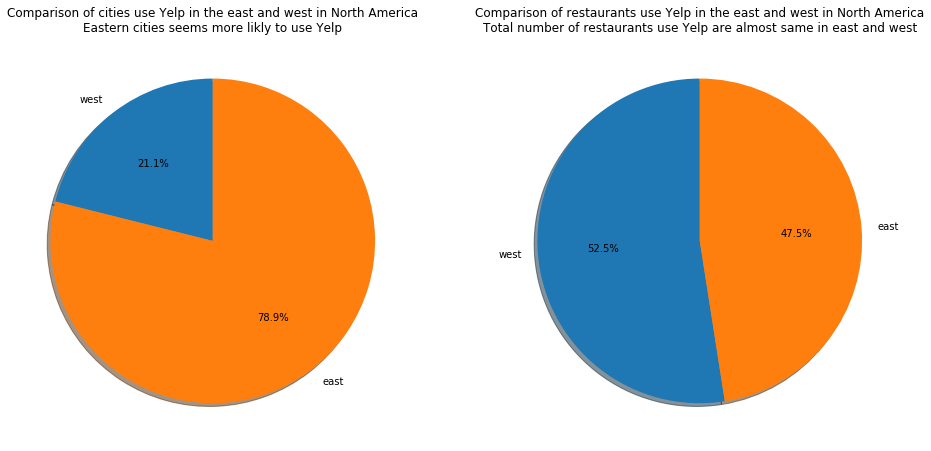

In [177]:
east_west = []
for i in range(len(loc_info_df)):
    if loc_info_df.longitude[i] < -100:
        east_west.append('west')
    else:
        east_west.append('east')

loc_info_df['region'] = east_west

sorted_loc_info_df = loc_info_df.sort_values(by=['count'], ascending=False).reset_index(drop=True)
west = loc_info_df[loc_info_df['region'] == 'west']
east = loc_info_df[loc_info_df['region'] == 'east']
labels = 'west', 'east'
total_cities_west = len(west)
total_cities_east = len(east)

west_total = sum(west['count'])
east_total = sum(east['count'])


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_title('Comparison of cities use Yelp in the east and west in North America\nEastern cities seems more likly to use Yelp')
ax[1].set_title('Comparison of restaurants use Yelp in the east and west in North America\nTotal number of restaurants use Yelp are almost same in east and west')

ax[0].pie([total_cities_west, total_cities_east], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].pie([west_total, east_total], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

Explanation of Visualization:

The pie char in the left represents the comparison of the number of cities in the east of North America and the number of cities in the west. On the other hand, the pie chart in the right above indicates the proportion of restaurants in the east and west seperatly. 

1. Number of cities use Yelp in the east of North America is more than the number of cities in the west.
2. Number of restaurants use Yelp in the east and west are almost same.

**Results:**
From the observation, results can be gained:
1. More cities would like to use Yelp in the east than in the west although Yelp is located in San Francisco, Yelp is more prevalent in eastern part of North America.
2. Compare to the popularity of cities use Yelp, total number of restaurants in east and west are almost same, which means the density of restaurants use Yelp is higher in the west.

The conclusion is Yelp is more popular among cities in the east than in the west while it is more prelavent in each of cities of the west than of the east.